### Imports 

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
from easyocr import Reader


### Loading our custom trained model to recognize license plates

In [28]:
model2 = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp6/weights/best.pt').to('cpu')

Using cache found in C:\Users\kba13/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-4-2 Python-3.11.8 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### Testing our model

In [29]:
image_url = 'data/car2.jpg'

results = model2(image_url)
results.render()

[array([[[211, 214, 219],
         [210, 213, 218],
         [209, 212, 217],
         ...,
         [212, 233, 250],
         [221, 238, 255],
         [221, 238, 255]],
 
        [[208, 211, 216],
         [208, 211, 216],
         [207, 210, 215],
         ...,
         [215, 236, 253],
         [219, 236, 255],
         [219, 236, 255]],
 
        [[204, 207, 212],
         [205, 208, 213],
         [207, 210, 215],
         ...,
         [201, 222, 239],
         [207, 224, 244],
         [207, 224, 244]],
 
        ...,
 
        [[182, 172, 171],
         [190, 180, 179],
         [201, 191, 190],
         ...,
         [166, 158, 145],
         [164, 156, 143],
         [164, 156, 143]],
 
        [[180, 170, 169],
         [183, 173, 172],
         [191, 181, 180],
         ...,
         [137, 130, 114],
         [138, 131, 115],
         [138, 131, 115]],
 
        [[187, 177, 176],
         [182, 172, 171],
         [178, 168, 167],
         ...,
         [120, 113,  95],
  

In [30]:
results.xywhn

[tensor([[0.53802, 0.58362, 0.80341, 0.47967, 0.98075, 1.00000],
         [0.49081, 0.74270, 0.27805, 0.05386, 0.96207, 0.00000]])]

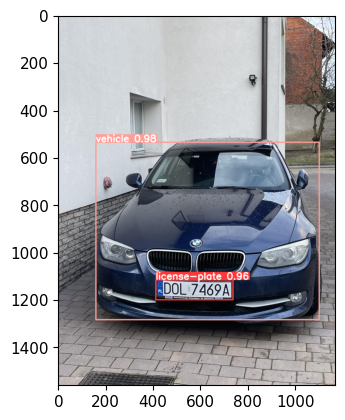

In [31]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

### Reading and printing license plate text into image

In [32]:
img_array = np.squeeze(results.render())


In [33]:
labels = np.squeeze(results.xyxy)
cars = []
license_plates = []

for label in labels:
    x1, y1, x2, y2, pred, class_id = label
    if class_id == 1:
        cars.append(label)
    else: 
        license_plates.append(label)
        
cars, license_plates

([array([     159.49,      536.31,      1099.5,      1284.6,     0.98075,           1], dtype=float32)],
 [array([     411.59,      1116.6,      736.91,      1200.6,     0.96207,           0], dtype=float32)])

In [34]:
class Car:
    def __init__(self, car_coords, plate_coords):
        self.car_coords = car_coords
        self.plate_coords = plate_coords
        self.plate_text = ''

    def __repr__(self):
        return f"Car(car_coords={self.car_coords}, plate_coords={self.plate_coords})"

In [35]:
def image_processing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, license_plate_thresh = cv2.threshold(gray, 64, 255, cv2.THRESH_BINARY_INV)
    return license_plate_thresh
        

DOL 74694


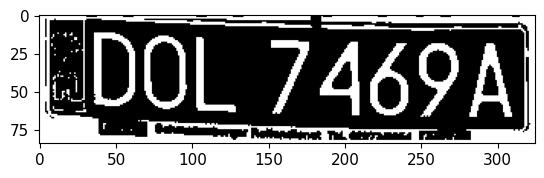

In [36]:
reader = Reader(['en'])
matched_cars = []  # Lista do przechowywania dopasowanych obiektów

for plate in license_plates:
    x1, y1, x2, y2, pred, class_id = plate
    for car in cars:
        x1car, y1car, x2car, y2car, p, c = car
        if x1car < x1 and x2car > x2 and y1car < y1 and y2car > y2:
            matched_cars.append(Car((int(x1car), int(y1car), int(x2car), int(y2car)), (int(x1), int(y1), int(x2), int(y2))))
            break

for matched_car in matched_cars:
    x1, y1, x2, y2 = matched_car.plate_coords
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    label_img = img_gray[y1:y2, x1:x2]
    _, license_plate_thresh = cv2.threshold(label_img, 84, 255, cv2.THRESH_BINARY_INV)
    label_result = reader.readtext(license_plate_thresh, batch_size=5)
    license_plate_text = ''
    
    for bbox, text, prob in label_result:
        license_plate_text += text
    
    matched_car.plate_text = license_plate_text    
    plt.imshow(license_plate_thresh, cmap='gray')
    print(matched_car.plate_text)
    
plt.show()

    

In [37]:
label_result = reader.readtext(label_img)
license_plate_text = ''

for bbox, text, prob in label_result:
    license_plate_text += text

license_plate_text

'DOL 74624'

In [38]:
image = cv2.imread(image_url)

for car in matched_cars:
    x1_car, y1_car, x2_car, y2_car = car.car_coords
    top_left_corner = (x1_car, y2_car)
    bottom_right_corner = (x2_car, y1_car)

# Arguments: image, top left corner, bottom right corner, color (BGR), thickness
    cv2.rectangle(image, top_left_corner, bottom_right_corner, (0, 255, 0), 3)

# Arguments: image, text, bottom left corner of the text, font, font scale, color, thickness
    cv2.putText(image, car.plate_text, (x1_car, y1_car-5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)

### Final result

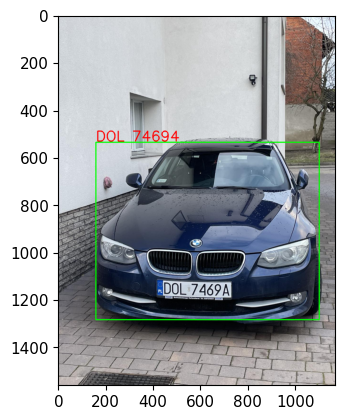

In [39]:
%matplotlib inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()